# Description

Create new features based on clients transaction history.

# Prepare data 


In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import chi2_contingency
import geocoder
import statistics
import time

In [2]:
%reload_kedro

/Users/xszpo/miniconda3/envs/viabill/lib/python3.8/site-packages/kedro/framework/project/__init__.py:133: UserWarning: Found duplicate pipeline entries. The following will be overwritten: __default__
  warn(


In [3]:
df_cust = catalog.load("customers")
d_sex = {1: 'male', 2:'female', 0: 'other'}
df_cust.sex = df_cust.sex.apply(lambda x: d_sex[x])

df_cust['residentialAddress_clean'] = df_cust.residentialAddress.apply(lambda x: re.sub(r'[0-9]+', '', x))
df_cust['postalAddress_clean']  = df_cust.postalAddress.apply(lambda x: re.sub(r'[0-9]+', '', x) if x==x else '')
df_cust['same_address'] = (df_cust.residentialAddress==df_cust.postalAddress).astype(int)


## Perform some basic future engineering

In [4]:
df_trans = catalog.load("transactions")
df_trans['late'] = df_trans.filter(regex='payment').apply(lambda x: x==1).any(axis=1).astype(int)
df_trans['default'] = df_trans.filter(regex='payment').apply(lambda x: x==2).any(axis=1).astype(int)

df_trans["defualted_payment"] = df_trans.replace({
    'paymentStatus1': {1: 0, 2: 1},
    'paymentStatus2': {1: 0, 2: 2},
    'paymentStatus3': {1: 0, 2: 3},
    'paymentStatus4': {1: 0, 2: 4},
}).filter(regex='payment').replace({0: np.nan}).min(axis=1).fillna(0)

df_trans["late_payment_first"] = df_trans.replace({
    'paymentStatus1': {1: 1, 2: 0},
    'paymentStatus2': {1: 2, 2: 0},
    'paymentStatus3': {1: 3, 2: 0},
    'paymentStatus4': {1: 4, 2: 0},
}).filter(regex='payment').replace({0: np.nan}).min(axis=1).fillna(0)

In [5]:
df_trans = df_trans.assign(
    money_lost = lambda x: x.apply(
        lambda y:y['price'] * (5-y['defualted_payment'])/4 if y['defualted_payment']>0 else 0, axis=1
    )
)

In [6]:
# mark transactions from shop 113 as a fraud
df_trans['fraud'] = 0
df_trans.loc[df_trans.shopID == 113, 'fraud'] = 1

In [7]:
# drop transaction marked as a fraud and transaction without customerID
df_trans = df_trans.loc[df_trans.fraud == 0].dropna(
    subset=['customerID']).reset_index(drop=True)

In [8]:
# rank customer transactions
df_trans['rank'] = df_trans.groupby("customerID")["transactionID"].rank(
    "dense", ascending=True)

In [9]:
# create default lag - informtion about default from previous cutomers
# transaction
df_trans['default_lag1'] = df_trans. \
    set_index('rank'). \
    groupby('customerID')[['default']]. \
    shift(1).reset_index(drop=True)

# create defualted_payment lag - informtion about number of defaulte
# payment from previous cutomers transaction
df_trans['defualted_payment_lag1'] = df_trans. \
    set_index('rank'). \
    groupby('customerID')[['defualted_payment']]. \
    shift(1).reset_index(drop=True)

# create lost lag - informtion about lost from previous cutomers
# transaction
df_trans['money_lost_lag1'] = df_trans. \
    set_index('rank'). \
    groupby('customerID')[['money_lost']]. \
    shift(1).reset_index(drop=True)

# create late payment lag - infroamtion about late payment from previous
# cutomer transaction
df_trans['late_lag1'] = df_trans. \
    set_index('rank'). \
    groupby('customerID')[['late']]. \
    shift(1).reset_index(drop=True)

# create price lag
df_trans['price_lag1'] = df_trans. \
    set_index('rank'). \
    groupby('customerID')[['price']]. \
    shift(1).reset_index(drop=True)

# create late_payment_first lag - informtion about number payment which
# was late as first from previous cutomers transaction
df_trans['late_payment_first_lag1'] = df_trans. \
    set_index('rank'). \
    groupby('customerID')[['late_payment_first']]. \
    shift(1).reset_index(drop=True)


In [10]:
# 
trans_back_aggreg_list = [3,6,9]

In [11]:
# aggregate data about previouse customer transactions using window
# functions

start_time = time.time()

aggreate_list = df_trans.filter(regex="lag").columns.to_list()

results = []
for i in trans_back_aggreg_list:

    print(f"starting aggregation for #{i} transactions back")
    names_sum = [f'{k}_lst_{str(i).zfill(2)}_sum' for k in list(map(lambda x: x.replace('_lag1',''), aggreate_list))]
    names_avg = [f'{k}_lst_{str(i).zfill(2)}_avg' for k in list(map(lambda x: x.replace('_lag1',''), aggreate_list))]

    if len(results) == 0 or len(trans_back_aggreg_list) <= 1:
        results += [pd.concat([
            df_trans.set_index('rank').groupby('customerID')[aggreate_list].rolling(i, min_periods=1).sum().reset_index(),
            df_trans.set_index('rank').groupby('customerID')[aggreate_list].rolling(i, min_periods=1).mean().reset_index().iloc[:, 2:]
            ], axis=1)]

        results[-1].columns = ['customerID', 'rank']+names_sum+names_avg
    else:
        results += [pd.concat([
            df_trans.set_index('rank').groupby('customerID')[aggreate_list].rolling(i, min_periods=1).sum().reset_index().iloc[:, 2:],
            df_trans.set_index('rank').groupby('customerID')[aggreate_list].rolling(i, min_periods=1).mean().reset_index().iloc[:, 2:]
            ], axis=1)]

        results[-1].columns = names_sum+names_avg

    print("--- %s seconds ---" % (time.time() - start_time))



starting aggregation for #3 transactions back
--- 603.1424798965454 seconds ---
starting aggregation for #6 transactions back
--- 1370.2203180789948 seconds ---
starting aggregation for #9 transactions back
--- 1882.3201460838318 seconds ---


In [12]:
defaults = pd.concat(results, axis=1)
df_trans_all = df_trans.merge(defaults, on=['customerID', 'rank'],
                              how='left')

In [13]:

# treat last customer transaction as current credit application
df_trans['rank_reverse'] = df_trans.groupby("customerID")["transactionID"]. \
    rank("dense", ascending=False)

In [14]:
# split transactions into current transaction and historical
df_trans_newest = df_trans.loc[df_trans.rank_reverse == 1]. \
    reset_index(drop=True)
df_trans_history = df_trans.loc[df_trans.rank_reverse > 1].\
    reset_index(drop=True)

In [15]:
# aggregate transaction history
df_trans_history_aggr = df_trans_history. \
    groupby('customerID'). \
    agg(
        hist_trans_count=('default', 'count'),
        hist_default_sum=('default', 'sum'),
        hist_default_avg=('default', 'mean'),
        hist_late_sum=('late', 'sum'),
        hist_late_avg=('late', 'mean'),
        hist_price_sum=('price', 'sum'),
        hist_price_avg=('price', 'mean')
    ).reset_index(drop=False)

In [16]:
# join historical transaction features created by aggregation all values
df_trans_newest = df_trans_newest.merge(
    df_trans_history_aggr, on='customerID', how='left')

# join historical transaction features created by window functions
df_trans = df_trans_newest.merge(
    defaults, on=['customerID', 'rank'], how='left')

In [17]:
master_table = df_cust.merge(df_trans, on=['customerID'], how='left')

In [18]:
# create geo risk ranking
# temporary solution, if used in final solution, need to prepare in fit/transform maner
bins = [-np.inf, 0.049, 0.071, 0.088, 0.107, 0.137, np.inf]
geo_risk_rank = master_table.groupby('residentialAddress_clean')[['hist_default_sum', 'hist_trans_count']]. \
    sum().reset_index(). \
    assign(geo_risk_rank=lambda x: pd.cut(x['hist_default_sum']/x['hist_trans_count'], bins).cat.codes)



In [19]:
master_table = master_table.merge(geo_risk_rank[['residentialAddress_clean', 'geo_risk_rank']], on='residentialAddress_clean', how='left')

# drop clients without transactions
master_table = master_table.dropna(subset=['default'])


In [20]:
master_table.describe().T

,count,mean,std,min,25%,50%,75%,max
customerID,490496.0,2.499744e+05,144333.696329,1.0,124989.75,249979.50,374975.25,500000.0
age,490496.0,4.463071e+01,16.176153,5.0,27.00,50.00,58.00,90.0
income,480711.0,4.999817e+04,28897.827794,0.0,25000.00,50000.00,75000.00,100000.0
same_address,490496.0,9.305377e-01,0.254239,0.0,1.00,1.00,1.00,1.0
transactionID,490496.0,1.534202e+06,418827.975187,76.0,1328190.75,1659686.50,1857921.25,2000000.0
...,...,...,...,...,...,...,...,...
money_lost_lst_09_avg,452775.0,4.558257e+00,13.223073,0.0,0.00,0.00,0.00,200.0
late_lst_09_avg,452775.0,2.947874e-01,0.322444,0.0,0.00,0.25,0.50,1.0
price_lst_09_avg,452775.0,1.014531e+02,37.435170,3.0,77.50,101.50,125.50,200.0
late_payment_first_lst_09_avg,452775.0,9.005973e-01,0.934349,0.0,0.00,0.75,1.50,4.0


## Perform some basic quality check

Check if rows in data in Master tables are not duplicated

In [21]:
if master_table.customerID.nunique() == master_table.shape[0]:
    print("Data in Master table are NOT duplicated.")
else:
    print("Data in Master table ARE duplicated.")

Data in Master table are NOT duplicated.


## Create  "geo risk rating"

rate addreses based on average risk 

In [22]:
master_table.columns

Index(['customerID', 'sex', 'age', 'residentialAddress', 'postalAddress',
       'income', 'residentialAddress_clean', 'postalAddress_clean',
       'same_address', 'transactionID', 'shopID', 'price', 'paymentStatus1',
       'paymentStatus2', 'paymentStatus3', 'paymentStatus4', 'late', 'default',
       'defualted_payment', 'late_payment_first', 'money_lost', 'fraud',
       'rank', 'default_lag1', 'defualted_payment_lag1', 'money_lost_lag1',
       'late_lag1', 'price_lag1', 'late_payment_first_lag1', 'rank_reverse',
       'hist_trans_count', 'hist_default_sum', 'hist_default_avg',
       'hist_late_sum', 'hist_late_avg', 'hist_price_sum', 'hist_price_avg',
       'default_lst_03_sum', 'defualted_payment_lst_03_sum',
       'money_lost_lst_03_sum', 'late_lst_03_sum', 'price_lst_03_sum',
       'late_payment_first_lst_03_sum', 'default_lst_03_avg',
       'defualted_payment_lst_03_avg', 'money_lost_lst_03_avg',
       'late_lst_03_avg', 'price_lst_03_avg', 'late_payment_first_lst_03_

In [23]:
_tmp = master_table.groupby('residentialAddress_clean')[['hist_default_sum','hist_trans_count']]. \
    sum().reset_index().assign(dr = lambda x: x['hist_default_sum']/x['hist_trans_count'])

<AxesSubplot:>

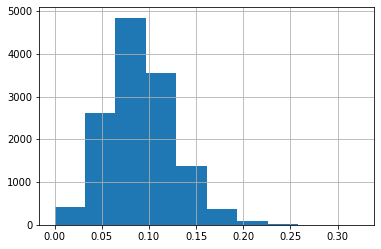

In [24]:
_tmp.dr.hist()

In [25]:
np.quantile(_tmp.dr, [i/10 for i in list(range(1,10,2))], axis=0)

array([0.04860437, 0.07142857, 0.08834466, 0.10666667, 0.1372549 ])

In [26]:
bins = [-np.inf, 0.049, 0.071, 0.088, 0.107, 0.137, np.inf]

In [27]:
geo_risk_rank = master_table.groupby('residentialAddress_clean')[['hist_default_sum','hist_trans_count']]. \
    sum().reset_index().assign(geo_risk_rank = lambda x: pd.cut(x['hist_default_sum']/x['hist_trans_count'], bins).cat.codes)


In [28]:
master_table = master_table.merge(geo_risk_rank[['residentialAddress_clean','geo_risk_rank']], on='residentialAddress_clean', how='left')

In [29]:
master_table

,customerID,sex,age,residentialAddress,postalAddress,income,residentialAddress_clean,postalAddress_clean,same_address,transactionID,...,price_lst_09_sum,late_payment_first_lst_09_sum,default_lst_09_avg,defualted_payment_lst_09_avg,money_lost_lst_09_avg,late_lst_09_avg,price_lst_09_avg,late_payment_first_lst_09_avg,geo_risk_rank_x,geo_risk_rank_y
0,1,male,25,28 Irvine Place,28 Irvine Place,NaN,Irvine Place,Irvine Place,1,1697842.0,...,358.0,1.0,0.000,0.00,0.0000,0.333333,119.333333,0.333333,4,4
1,2,male,19,72 Bertha Street,72 Bertha Street,43200.0,Bertha Street,Bertha Street,1,1834257.0,...,599.0,2.0,0.000,0.00,0.0000,0.333333,99.833333,0.333333,2,2
2,3,female,22,63 Ladberry Street,63 Ladberry Street,70200.0,Ladberry Street,Ladberry Street,1,1974624.0,...,781.0,4.0,0.125,0.25,6.1875,0.125000,97.625000,0.500000,1,1
3,4,other,24,98 Linneman Close,98 Linneman Close,93900.0,Linneman Close,Linneman Close,1,1536291.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3
4,5,male,53,56 Salonica Road,56 Salonica Road,77000.0,Salonica Road,Salonica Road,1,661121.0,...,289.0,10.0,0.500,1.75,13.5625,0.500000,72.250000,2.500000,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490491,499996,male,68,95 Argyle Parade,95 Argyle Parade,40500.0,Argyle Parade,Argyle Parade,1,665043.0,...,173.0,0.0,0.000,0.00,0.0000,0.000000,173.000000,0.000000,4,4
490492,499997,female,22,34 Bearke Place,34 Bearke Place,44900.0,Bearke Place,Bearke Place,1,1756533.0,...,181.0,0.0,0.000,0.00,0.0000,0.000000,90.500000,0.000000,2,2
490493,499998,male,27,95 Glenhurst Street,95 Glenhurst Street,48700.0,Glenhurst Street,Glenhurst Street,1,1628579.0,...,354.0,0.0,0.000,0.00,0.0000,0.000000,88.500000,0.000000,0,0
490494,499999,male,55,34 Kiandra Close,34 Kiandra Close,7600.0,Kiandra Close,Kiandra Close,1,1722718.0,...,664.0,0.0,0.000,0.00,0.0000,0.000000,132.800000,0.000000,1,1


# Model - initial model only to get intuition about model features

In [38]:
categorical_cols = ['sex', 'residentialAddress_clean','postalAddress_clean',
                    'shopID',
                    'same_address']
numerical_cols = ['age', 'income', 'price'] + \
    master_table.filter(regex='(^hist_)|(_lst_)').columns.to_list()

target_def = 'default'
target_late = 'late'

In [39]:
[i for i in categorical_cols if i not in master_table.columns]

[]

In [40]:
[i for i in numerical_cols if i not in master_table.columns]

[]

In [41]:
import numpy as np
from category_encoders import *

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn import metrics

import lightgbm as lgb

In [42]:
pipe = ColumnTransformer([
        ('num','passthrough',numerical_cols),
        ('te', WOEEncoder(), categorical_cols),
    ])

In [43]:
#df_cust_trans_new_cust = df_cust_trans.loc[df_cust_trans['rank']==1].reset_index(drop=True)
#df_cust_trans_old_cust = df_cust_trans.loc[df_cust_trans['rank']>1].reset_index(drop=True)

In [44]:
#df_tr_cust_trans_new_cust = pipe_new.fit_transform(df_cust_trans_new_cust, df_cust_trans_new_cust.default)
#df_tr_cust_trans_old_cust= pipe_old.fit_transform(df_cust_trans_old_cust, df_cust_trans_old_cust.default)


In [45]:
df_tr_cust_trans = pipe.fit_transform(master_table, master_table.default)

In [46]:
master_table.drop(columns=['geo_risk_rank_x','geo_risk_rank_y'], inplace=True)

In [47]:
d_train = lgb.Dataset(
    df_tr_cust_trans, 
    label=master_table.default, 
    feature_name=pipe.get_feature_names())

In [48]:
lgb_params = {#"learning_rate": 0.01,
              #"num_leaves": 16,
              #"min_data_in_leaf": 20,
              #"max_depth": 20,
              #"boosting": "gbdt",
              "num_iterations": 500,
              #"bagging_fraction": 0.6,
              #"feature_fraction": 1.0,
              "seed": 42,
              "num_threads": -1,
              "objective": "binary", 
              "metric": "auc"
              }

In [49]:
cv_results = lgb.cv(lgb_params, d_train, nfold=5, verbose_eval=20, early_stopping_rounds=40)

/Users/xszpo/miniconda3/envs/viabill/lib/python3.8/site-packages/lightgbm/engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 35688, number of negative: 356708
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5592
[LightGBM] [Info] Number of data points in the train set: 392396, number of used features: 51
[LightGBM] [Info] Number of positive: 35688, number of negative: 356709
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.322672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5592
[LightGBM] [Info] Number of data points in the train set: 392397, number of used features: 51
[LightGBM] [Info] Number of positive: 35688, number of negative: 356709
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.179838 seconds.
You can set `force_row_wise

/Users/xszpo/miniconda3/envs/viabill/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 44610, number of negative: 445886
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.187512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5592
[LightGBM] [Info] Number of data points in the train set: 490496, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090949 -> initscore=-2.302105
[LightGBM] [Info] Start training from score -2.302105


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

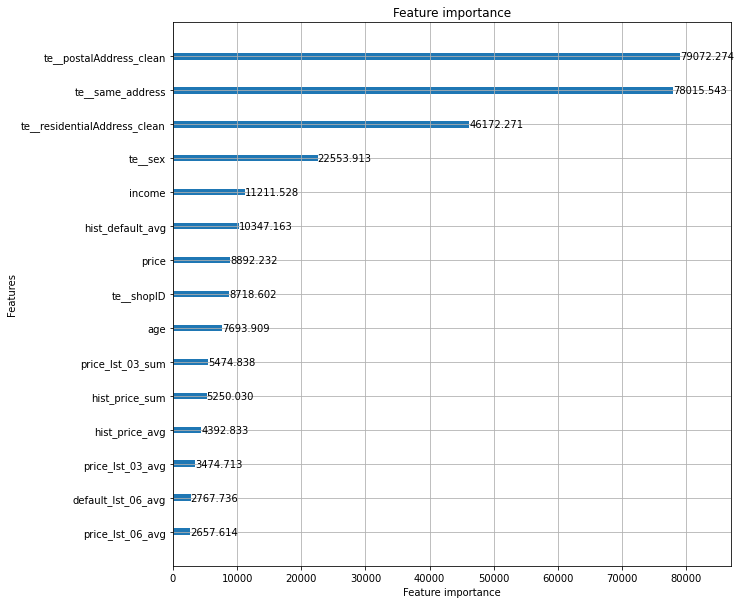

In [50]:
model= lgb.train(lgb_params, d_train)
fig, ax2 = plt.subplots(figsize=(10,10))
lgb.plot_importance(model, max_num_features=15, ax=ax2, importance_type = 'gain')